## Section 1: Initial settings 

#### 1.1 Importing packages

In [55]:
import rebound 

import sympy as sp
from matplotlib import pyplot as plt
from matplotlib import pyplot

import numpy as np
from numpy import cos, sin, arcsin, arccos, arctan

from sympy import init_printing
init_printing

%matplotlib inline

# plot style and colour
plt.style.use('seaborn')
plt.rcParams['axes.facecolor'] = 'whitesmoke'

# plot border
plt.rcParams["axes.edgecolor"] = '0'
plt.rcParams["axes.linewidth"] = 0.7

#### 1.2 Conversion and time 

In [56]:
rad_mas = 206264806
rad_as  = 206264806/1000
as_mas  = 1000
AU_pc   = 4.84814e-6
as_rad = 4.84814e-6

timescale = 4.2
m         = 200
times     = np.linspace(0,timescale,num = m)

#### 1.3 Setting parameters

In [57]:
# star parameters 
m_star  = 1                                                   # mass of stat                        [M_solar]
vy_star = 4.74*(50*0.001)*(50)* (1/1.496e+8) * (3.154e+7)     # velocity of star in y direction     [AU/year]
vz_star = 1.7*vy_star                                         # velocity of star in z direction     [AU/year]

# planet parameters 
inc           = 0.2                                            # orbital inclination                 [rad]
m_planet      = 0.0143188                                     # mass of planet                      [M_solar]
a_AU          = 0.6                                           # semi-major axis                     [AU]
e             = 0.2                                           # ellipticity of the orbit            [unitless]
omega         = 2                                             # argument of perihelion              [rad] 
OMEGA         = 1                                             # longitude of the ascending node     [rad]
tau           = 0                                             # time of pericentre passage          [years]
t0            = 0                                             # wrt Julian date                     [years]
proper_motion = 0.05                                          # proper motion of the system         [as/year]

# earth parameters
a_earth = 1

## Section 2: Functions

#### 2.1 Function called $get\_simulation$ that creates simulation with and without planet from initial conditions

In [58]:
def get_simulation(delta=0, alpha=0, d=1.031e7, m_star = m_star, vy_star = vy_star, vz_star=vz_star, m_planet=m_planet, inc=inc, a_AU=a_AU, e=e,omega=omega,Omega=OMEGA):
    # with planet 
    x_star= d*cos(alpha)*cos(delta)
    y_star = d*cos(delta)*sin(alpha)
    z_star = d*sin(delta)
    
    sim_wp = rebound.Simulation()                                                        # create a simulation named sim_wp 

    sim_wp.units = ["msun","AU","year"]                                                  # setting units of sim_wpm

    sim_wp.add(m = 1)                                                                    # add the Sun as the central object 

    sim_wp.add(m = 3.0027e-6, a = 1, e = 0)                                              # add Earth in a 1 AU circular orbit 
    
    sim_wp.add(x = x_star, y=y_star, z=z_star, vy = vy_star, m = m_star, vz = vz_star)          # add a star 50 pc away with calculated velocity and set parameters

    sim_wp.add(m = m_planet, a = a_AU, e = e, primary = sim_wp.particles[2], inc = inc, M=0,omega=omega,Omega=Omega)  # add planet from figure 3.1 caption and have it orbit the star 
    
    # barycentre particles
    com_particle  = sim_wp.calculate_com(first = 2,last = 4)
    ssbc_particle = sim_wp.calculate_com(first = 0,last = 2)
    
    # without planet
    sim = rebound.Simulation()                                                           # create a simulation named sim 

    sim.units = ["msun","AU","year"]                                                     # setting units of sim 

    sim.add(m = 1)                                                                       # add the Sun as the central object 

    sim.add(m = 3.0027e-6, a = 1, e = 0)                                                 # add Earth in a 1 AU circular orbit 

    sim.add(com_particle)                                                                # add a particle equivaent to the star-planet barycentre
    
    return(sim_wp, sim)

#### 2.2 Function called $simple\_function$ takes in a position vector and returns  $d, \delta$ and $\alpha$ 

In [59]:
def simple_function(R):
    Rx, Ry, Rz = R
    
    rho = np.sqrt(Rx**2+Ry**2)
    
    d      = np.linalg.norm(R, axis=0)
    delta  = np.arctan2(Rz, rho)
    alpha  = np.arctan2(Ry, Rx)
    
    return(d, delta,alpha)

#### 2.3 function called $simulation\_function$ uses a simulation and returns $delta$ and $alpha$ for the two vectors $r\_star - r\_earth$ and $r\_star - r\_ssbc$, as well as the intial conditions $R\_SC\_0$ and $V\_SC\_0$ needed for $equations\_function$

In [60]:
def sim_function(sim, times=times):
    # making arrays filled with zeros 
    r_ssbc, r_earth, r_star = np.zeros((m,3)), np.zeros((m,3)), np.zeros((m,3))
    v_ssbc, v_star,  = np.zeros((m,3)), np.zeros((m,3))
    R_SE, delta_SE, alpha_SE = np.zeros((m,3)), np.zeros(m), np.zeros(m)
    R_SC, delta_SC, alpha_SC = np.zeros((m,3)), np.zeros(m), np.zeros(m)
    
    for i,t in enumerate(times):
        # integrate simulations
        sim.integrate(t)
        sim_wp.integrate(t)
        
        # set particles 
        ssbc_particle   = sim.calculate_com(first = 0,last = 2)  # solar system barycentre 
        earth_particle  = sim.particles[1]                       # earth 
        star_particle   = sim.particles[2]                       # star 
        
        # positions of particles 
        r_ssbc[i] = np.array(ssbc_particle.xyz)
        r_earth[i] = np.array(earth_particle.xyz)
        r_star[i] = np.array(star_particle.xyz)
        
        # position vectors 
        R_SE[i] = r_star[i] - r_earth[i]  # star - earth 
        R_SC[i] = r_star[i] - r_ssbc[i]   # star - ssbc 
    
        # using simple_function to turn position vectros into delta and alpha
        _, delta_SE[i], alpha_SE[i] = simple_function(R_SE[i])  # star - earth 
        _, delta_SC[i], alpha_SC[i] = simple_function(R_SC[i])  # star - ssbc 
        
        # velocities 
        v_ssbc[i]   = np.array(ssbc_particle.vxyz)    # ssbc
        v_star[i]   = np.array(star_particle.vxyz)    # star  
        
        # initial conditions needed for other functions 
        R_SC_0 = r_star[0] - r_ssbc[0]
        V_SC_0 = v_star[0] - v_ssbc[0]
            
    return(delta_SE, alpha_SE, delta_SC, alpha_SC, R_SC_0, V_SC_0)

In [61]:
def E_from_M(e,M, tol=1e-10):
    E = M
    f=np.inf
    while np.abs(f) > (tol):
        f = E-e*sin(E)-M
        f_prime = 1-e*cos(E)
        E = E -f/f_prime
    return(E)

#### 2.4 Function called $equations\_function$ that takes in a position and velocity vector and returns proper motion and parallax terms of stellar motion

In [62]:
def equations_function(R, V, times=times, t0=t0, a_earth = a_earth, G=4*np.pi*np.pi, m_star = m_star, m_planet=m_planet, a_AU=a_AU, tau=tau, e=e, omega=omega, OMEGA=OMEGA, inc=inc):
    
    # finding initial values of d_bc, delta_bc and alpha_bc 
    d, delta, alpha = simple_function(R)
    
    # finding initial values of d_dot_bc, delta_dot_bc and alpha_dot_bc
    Vx, Vy, Vz = V 
    sind, cosd, sina, cosa  = sin(delta), cos(delta), sin(alpha), cos(alpha)
    
    d_dot     =   Vx * cosa * cosd      +  Vy * sina * cosd     +  Vz * sind
    delta_dot = -(Vx * sind * cosa)/d   - (Vy * sina * sind)/d  + (Vz * cosd)/d  # proper motion in dec direction [rad/year]
    alpha_dot = -(Vx * sina)/(d * cosd) + (Vy * cosa)/(d*cosd)                   # proper motion in ra direction [rad/year]
    

    T = times - t0  # time variable T                                                                    [years]

    pm_term_dec = delta_dot*T  # proper motion term in dec direction                                     [rad]
    pm_term_ra  = alpha_dot*T  # proper motion term in ra direction                                      [rad]
    
    # parallax term 
#     prlx_term_dec = (a_earth/d)*sind*cos(2*np.pi*T-alpha)                                     #    [rad]
#     prlx_term_ra  = (a_earth/(d*cosd))*(sina*cos(2*np.pi*T)-cosa*sin(2*np.pi*T))  #    [rad]
    
    # planetary term
#     parallax = 1/(d*AU_pc)                                           # parallax of the star              [as]
#     m_tot = m_star + m_planet
#     rtGM = np.sqrt(G * m_tot)
#     P = 2*np.pi * a_AU**(3/2)/rtGM                                                  # period of the planet              [years]
#     a_as = 1#((parallax*m_planet)**3*(P/(m_star+m_planet))**2)**(1/3)  # angular semi-major axis           [as]
    
    # Thiele-Innes constants 
#     A = a_as * (  cos(omega)  * cos(OMEGA) - sin(omega) * sin(OMEGA) * cos(inc))  #                      [as]
#     F = a_as * ( - sin(omega) * cos(OMEGA) - cos(omega) * sin(OMEGA) * cos(inc))  #                      [as]
    
#     B = a_as * (  cos(omega)  * sin(OMEGA) + sin(omega) * cos(OMEGA) * cos(inc))  #                      [as]
#     G = a_as * ( - sin(omega) * sin(OMEGA) + cos(omega) * cos(OMEGA) * cos(inc))  #                      [as]
    
#     H = a_as * sin(omega)*sin(inc)
#     C = a_as * sin(inc)*cos(omega)

#     M = (2*np.pi)*(times - tau)/P  # mean anomaly [rad]
#     E = np.vectorize(E_from_M)(e,M)
    
#     X = a_AU * (cos(E)-e)   
#     Y = a_AU *(np.sqrt((1-e**2))*sin(E))
    
#     DELTA_X = A*X+F*Y              #      [AU]
#     DELTA_Y = B*X+G*Y              #      [AU]
#     DELTA_Z = H*X+C*Y                                                   #      [AU]
    
#     mass_ratio = m_planet/m_tot
#     planetary_term_dec = -(mass_ratio/d)*cosd*DELTA_Z + (mass_ratio/d)*sind*(DELTA_X*cosa+DELTA_Y*sina)
#     planetary_term_ra  = (1/(d*cosd)) * (m_planet/(m_star + m_planet)) * (sina*DELTA_X-cosa*DELTA_Y)  #  [rad]
    return(pm_term_dec, pm_term_ra)
    #return (pm_term_dec, pm_term_ra, prlx_term_dec, prlx_term_ra, planetary_term_dec, planetary_term_ra)

## Section 3: Using functions

#### 3.1 Simulation

In [67]:
# start simulations using get_simulation
sim_wp, sim = get_simulation(np.pi/4, np.pi/4)

# setting values for the without planet simulation
sim_values = sim_function(sim)
delta_SE_np, alpha_SE_np, delta_SC_np, alpha_SC_np, R_SC_0_np, V_SC_0_np = sim_values

# setting values for the with planet simulation using sim_function and sim_planet_function
sim_wp_values = sim_function(sim_wp)
delta_SE_wp, alpha_SE_wp, delta_SC_wp, alpha_SC_wp, R_SC_0_wp, V_SC_0_wp = sim_wp_values

#### 3.2 Equations 

In [68]:
# no planet 
equation_values_np = equations_function(R_SC_0_np, V_SC_0_np)
pm_term_dec_np, pm_term_ra_np= equation_values_np 


# with planet
equation_values_wp = equations_function(R_SC_0_wp, V_SC_0_wp)
pm_term_dec_wp, pm_term_ra_wp = equation_values_wp



In [69]:
# no planet 
# equation_values_np = equations_function(R_SC_0_np, V_SC_0_np)
# pm_term_dec_np, pm_term_ra_np, prlx_term_dec_np, prlx_term_ra_np, _, _ = equation_values_np 

# signal_ra_np  = pm_term_ra_np  + prlx_term_ra_np
# signal_dec_np = pm_term_dec_np + prlx_term_dec_np 

# with planet
# equation_values_wp = equations_function(R_SC_0_wp, V_SC_0_wp)
# pm_term_dec_wp, pm_term_ra_wp, prlx_term_dec_wp, prlx_term_ra_wp, planetary_term_dec, planetary_term_ra = equation_values_wp

# signal_ra_wp  = pm_term_ra_wp  + prlx_term_ra_wp  + planetary_term_ra  
# signal_dec_wp = pm_term_dec_wp + prlx_term_dec_wp + planetary_term_dec 

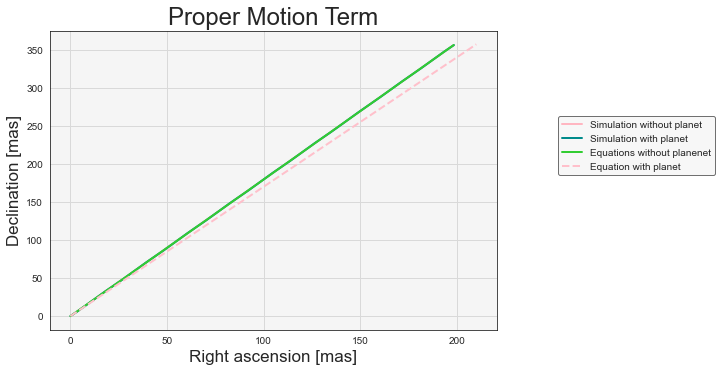

In [70]:
# plotting data 

plt.plot((alpha_SC_np-alpha_SC_np[0])*rad_mas, 
         (delta_SC_np-delta_SC_np[0])*rad_mas, 
         color='lightpink', 
         lw=2, 
         label = 'Simulation without planet')

plt.plot((alpha_SC_wp-alpha_SC_wp[0])*rad_mas, 
         (delta_SC_wp-delta_SC_wp[0])*rad_mas, 
         color='darkcyan', 
         lw=2, 
         label = 'Simulation with planet')

plt.plot(pm_term_ra_np*rad_mas, 
         pm_term_dec_np*rad_mas, 
         color='limegreen', 
         lw=2,           
         label = 'Equations without planenet')

plt.plot(pm_term_ra_wp*rad_mas, 
         pm_term_dec_wp*rad_mas, 
         color='pink', 
         lw=2,           
         ls='--', 
         label = 'Equation with planet')

# set titles 
plt.title('Proper Motion Term', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

## Section 4: Plots

#### 4.1 Signal from simulation

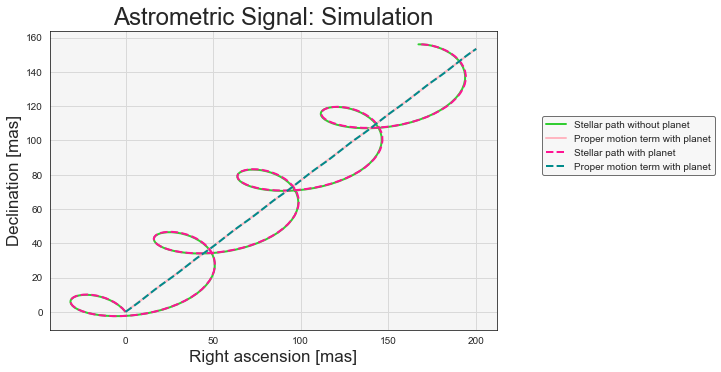

In [49]:
# plotting data 
plt.plot((alpha_SE_np-alpha_SE_np[0])*rad_mas, 
         (delta_SE_np-delta_SE_np[0])*rad_mas, 
         color='limegreen', 
         lw=2,           
         label = 'Stellar path without planet')

plt.plot((alpha_SC_np-alpha_SC_np[0])*rad_mas, 
         (delta_SC_np-delta_SC_np[0])*rad_mas, 
         color='lightpink', 
         lw=2, 
         label = 'Proper motion term with planet')

plt.plot((alpha_SE_wp-alpha_SE_wp[0])*rad_mas, 
        (delta_SE_wp-delta_SE_wp[0])*rad_mas, 
         color='deeppink', 
         lw=2, 
         ls='--', 
         label = 'Stellar path with planet')

plt.plot((alpha_SC_wp-alpha_SC_wp[0])*rad_mas, 
         (delta_SC_wp-delta_SC_wp[0])*rad_mas, 
         color='darkcyan', 
         lw=2, 
         ls='--', 
         label = 'Proper motion term with planet')


# set titles 
plt.title('Astrometric Signal: Simulation', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

#### 4.2 Planetary

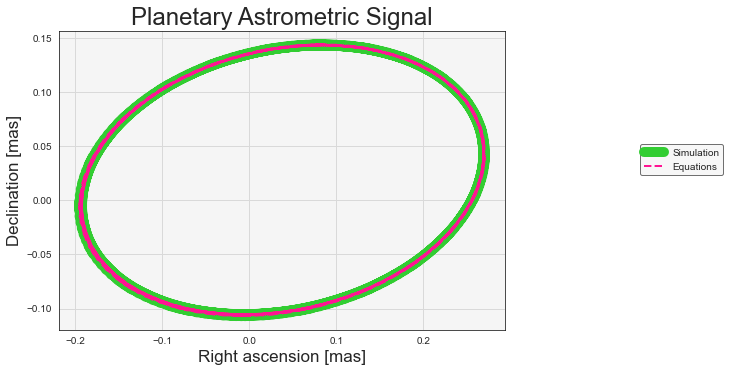

In [50]:
# plotting data 

ra_diff = alpha_SE_wp - alpha_SE_np
dec_diff = (delta_SE_wp) - (delta_SE_np)

plt.plot(ra_diff*rad_mas, 
         dec_diff*rad_mas, 
         color='limegreen', 
         lw=10,           
         label = 'Simulation')

plt.plot(planetary_term_ra*rad_mas, 
         planetary_term_dec*rad_mas, 
         color='deeppink', 
         lw=2,
         ls='--',
         label = 'Equations')

# set titles 
plt.title('Planetary Astrometric Signal', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

#### 4.3 Equations plots

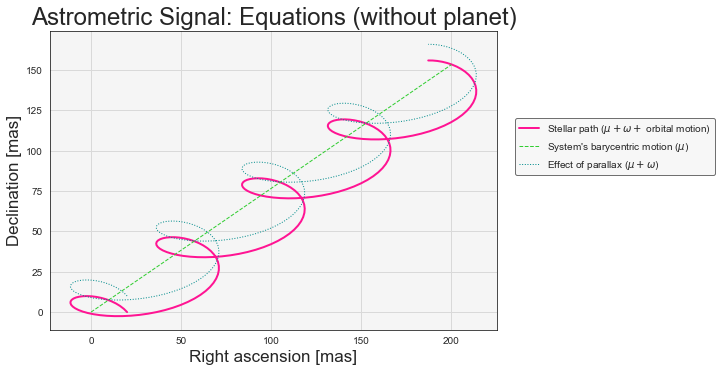

In [51]:
# plotting data without planet 
plt.plot(signal_ra_np*rad_mas, 
         (signal_dec_np-signal_dec_np[0])*rad_mas, 
         color='deeppink', 
         lw=2,
         label = 'Stellar path ($\mu + \omega +$ orbital motion)')

plt.plot(pm_term_ra_np*rad_mas, 
         pm_term_dec_np*rad_mas, 
         color='limegreen', 
         lw=1,           
         ls='--', 
         label = 'System\'s barycentric motion ($\mu$)')

plt.plot(signal_ra_np*rad_mas, 
         signal_dec_np*rad_mas, 
         color='darkcyan', 
         lw=1, 
         ls='dotted', 
         label = 'Effect of parallax ($\mu + \omega $)')

# set titles 
plt.title('Astrometric Signal: Equations (without planet)', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

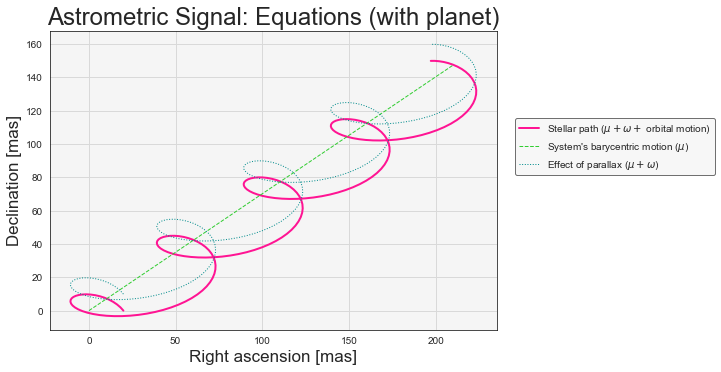

In [52]:
# plotting data with planet 
plt.plot(signal_ra_wp*rad_mas, 
         (signal_dec_wp-signal_dec_wp[0])*rad_mas, 
         color='deeppink', 
         lw=2,
         label = 'Stellar path ($\mu + \omega +$ orbital motion)')

plt.plot(pm_term_ra_wp*rad_mas, 
         pm_term_dec_wp*rad_mas, 
         color='limegreen', 
         lw=1,           
         ls='--', 
         label = 'System\'s barycentric motion ($\mu$)')

plt.plot(signal_ra_wp*rad_mas, 
         signal_dec_wp*rad_mas, 
         color='darkcyan', 
         lw=1, 
         ls='dotted', 
         label = 'Effect of parallax ($\mu + \omega $)')

# set titles 
plt.title('Astrometric Signal: Equations (with planet)', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

####  4.4 Comparing simulation vs equations

##### 4.4.1 Without planet

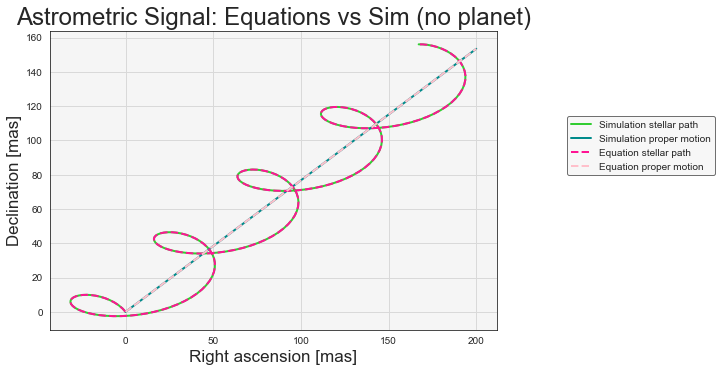

In [53]:
# plotting data without planet 
plt.plot((alpha_SE_np-alpha_SE_np[0])*rad_mas, 
        (delta_SE_np-delta_SE_np[0])*rad_mas, 
         color='limegreen', 
         lw=2, 
         label = 'Simulation stellar path')

plt.plot((alpha_SC_np-alpha_SC_np[0])*rad_mas, 
         (delta_SC_np-delta_SC_np[0])*rad_mas, 
         color='darkcyan', 
         lw=2, 
         label = 'Simulation proper motion')


plt.plot((signal_ra_np-signal_ra_np[0])*rad_mas, 
         (signal_dec_np-signal_dec_np[0])*rad_mas, 
         color='deeppink', 
         lw=2,
         ls='--', 
         label = 'Equation stellar path')

plt.plot(pm_term_ra_np*rad_mas, 
         pm_term_dec_np*rad_mas, 
         color='pink', 
         lw=2,           
         ls='--', 
         label = 'Equation proper motion')

# set titles 
plt.title('Astrometric Signal: Equations vs Sim (no planet)', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

##### 4.4.2 With planet

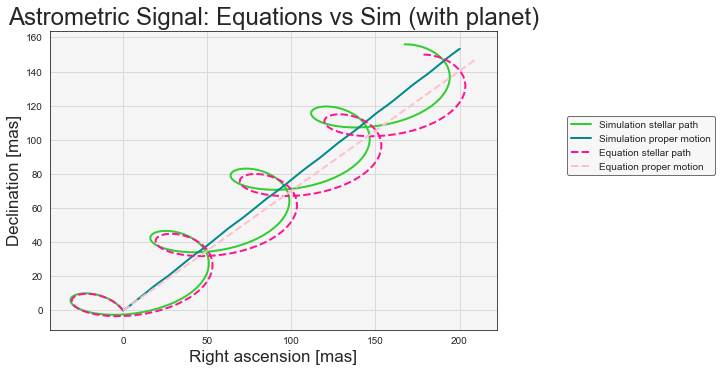

In [55]:
# plotting data with planet 
plt.plot((alpha_SE_wp-alpha_SE_wp[0])*rad_mas, 
        (delta_SE_wp-delta_SE_wp[0])*rad_mas, 
         color='limegreen', 
         lw=2, 
         label = 'Simulation stellar path')

plt.plot((alpha_SC_wp-alpha_SC_wp[0])*rad_mas, 
         (delta_SC_wp-delta_SC_wp[0])*rad_mas, 
         color='darkcyan', 
         lw=2, 
         label = 'Simulation proper motion')

plt.plot((signal_ra_wp-signal_ra_wp[0])*rad_mas, 
         (signal_dec_wp-signal_dec_wp[0])*rad_mas, 
         color='deeppink', 
         lw=2,
         ls='--', 
         label = 'Equation stellar path')

plt.plot(pm_term_ra_wp*rad_mas, 
         pm_term_dec_wp*rad_mas, 
         color='pink', 
         lw=2,           
         ls='--', 
         label = 'Equation proper motion')


# set titles 
plt.title('Astrometric Signal: Equations vs Sim (with planet)', fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)